**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [475]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the data

In [578]:
import pandas as pd

housing = pd.read_csv("insurance.csv")

In [579]:
housing.head(7)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960


<AxesSubplot:xlabel='region', ylabel='charges'>

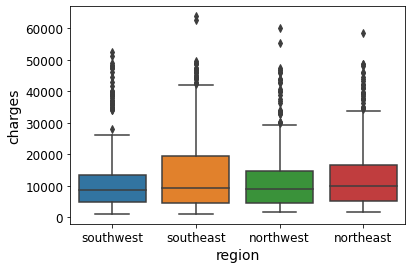

In [580]:
sns.boxplot(x = "region", y = "charges", data = housing)

In [581]:
housing.drop("region", axis=1, inplace=True)

In [582]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 62.8+ KB


In [482]:
housing.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Saving figure attribute_histogram_plots


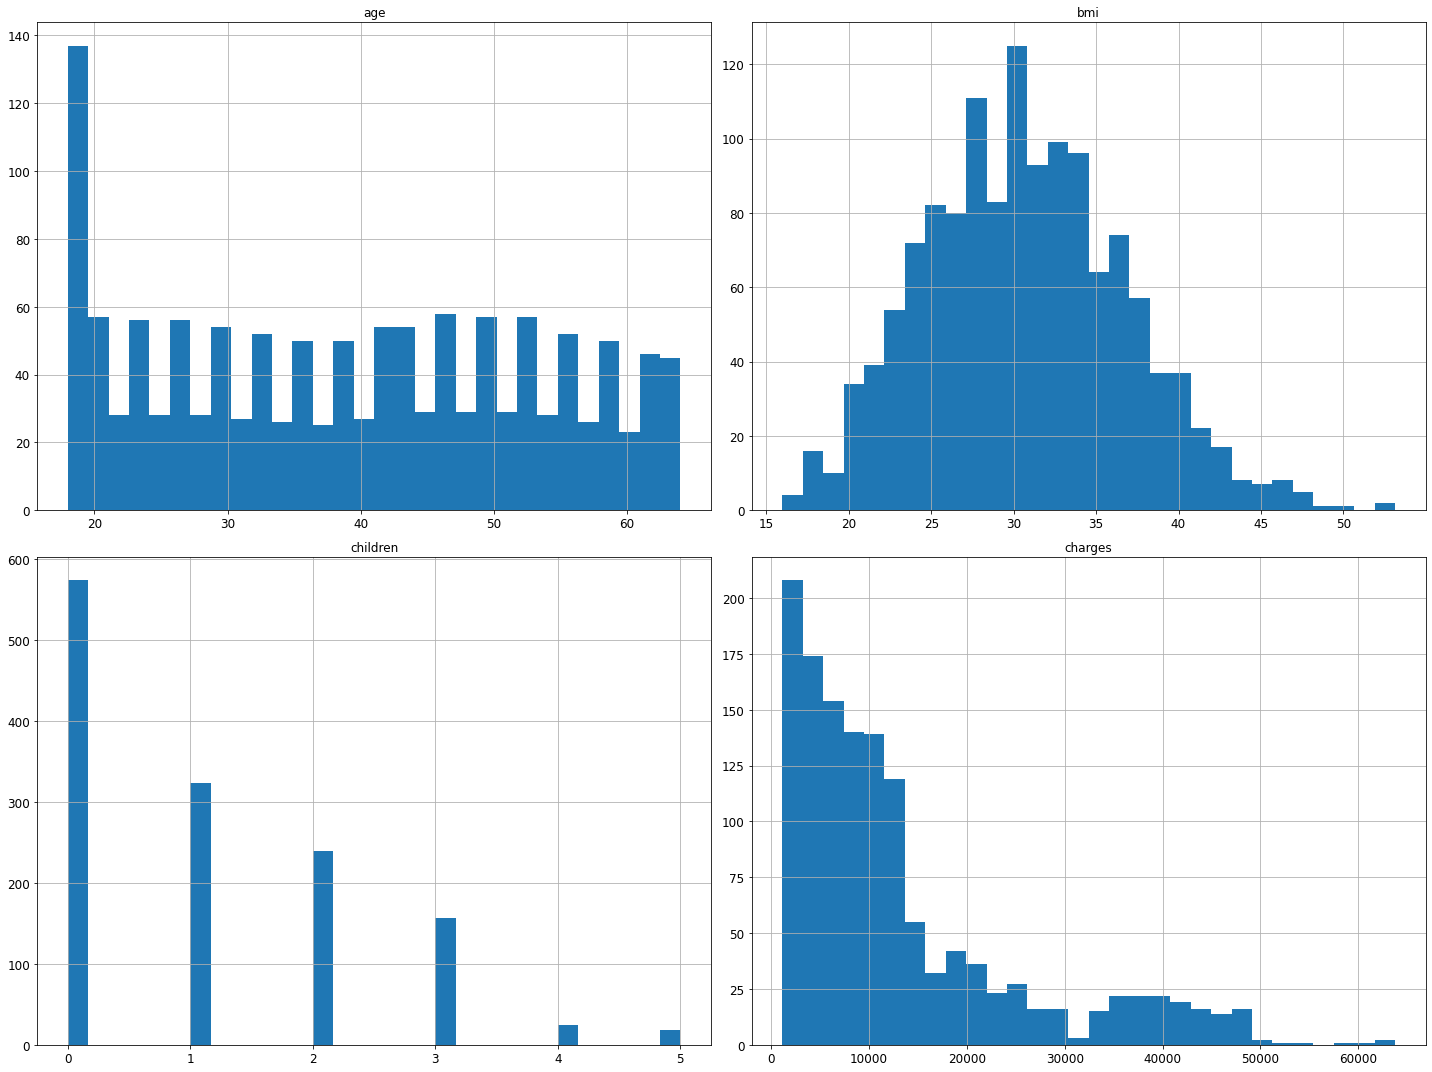

In [483]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=30, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [484]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [485]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [486]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

1071

In [487]:
len(test_set)

267

In [488]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:

In [489]:
test_set.head()

,age,sex,bmi,children,smoker,charges
764,45,female,25.175,2,no,9095.06825
887,36,female,30.020,0,no,5272.17580
890,64,female,26.885,0,yes,29330.98315
1293,46,male,25.745,3,no,9301.89355
259,19,male,31.920,0,yes,33750.29180


In [490]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [491]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["smoker"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [492]:
strat_test_set["smoker"].value_counts() / len(strat_test_set)

no     0.794776
yes    0.205224
Name: smoker, dtype: float64

In [493]:
housing["smoker"].value_counts() / len(housing)

no     0.795217
yes    0.204783
Name: smoker, dtype: float64

# Discover and visualize the data to gain insights

In [494]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


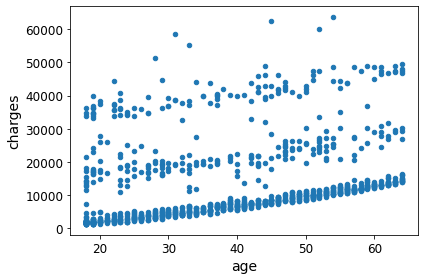

In [495]:
housing.plot(kind="scatter", x="age", y="charges")
save_fig("bad_visualization_plot")

No handles with labels found to put in legend.


Saving figure housing_prices_scatterplot


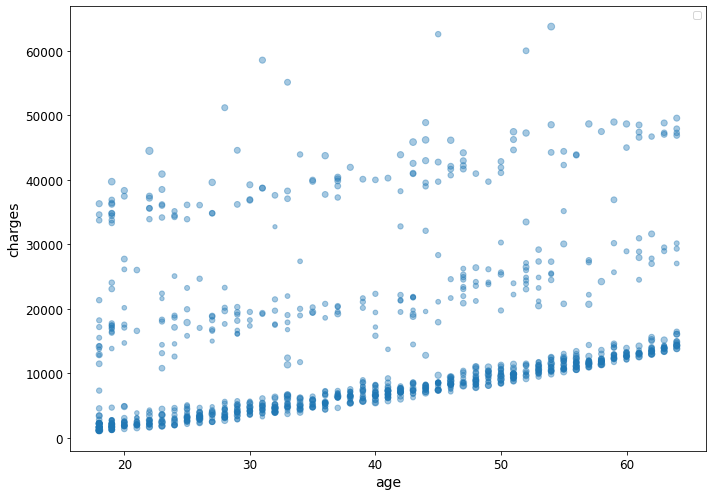

In [496]:
housing.plot(kind="scatter", x="age", y="charges", alpha=0.4,
             s=housing["bmi"], figsize=(10,7), sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [497]:
corr_matrix = housing.corr()

In [498]:
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.291370
bmi         0.185565
children    0.061811
Name: charges, dtype: float64

Saving figure scatter_matrix_plot


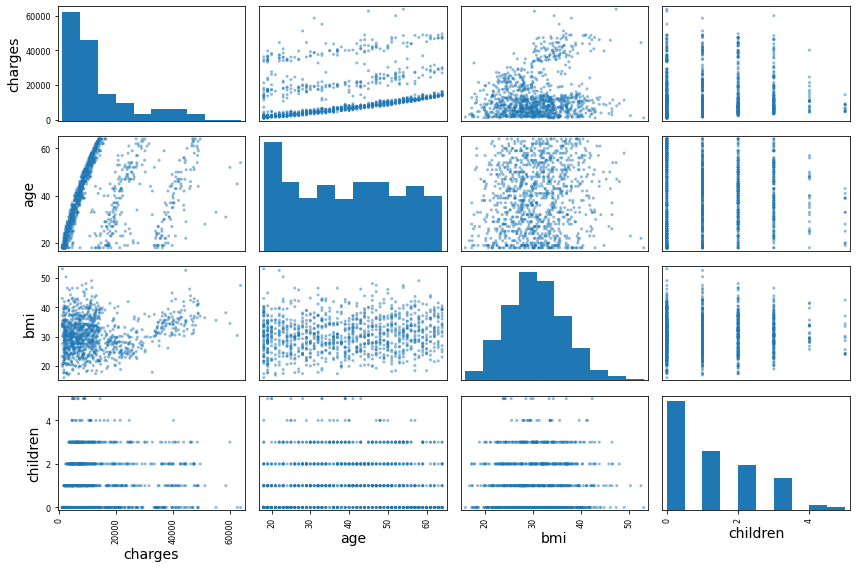

In [499]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["charges", "age", "bmi",
              "children"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


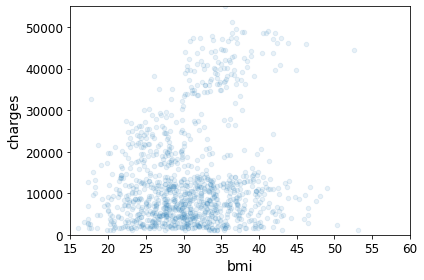

In [500]:
housing.plot(kind="scatter", x="bmi", y="charges",
             alpha=0.1)
plt.axis([15, 60, 0, 55000])
save_fig("income_vs_house_value_scatterplot")

In [501]:
corr_matrix = housing.corr()
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.291370
bmi         0.185565
children    0.061811
Name: charges, dtype: float64

In [502]:
housing.describe()

,age,bmi,children,charges
count,1070.000000,1070.000000,1070.000000,1070.000000
mean,39.131776,30.768294,1.106542,13285.111927
std,14.037915,6.046076,1.210283,12100.847317
min,18.000000,15.960000,0.000000,1121.873900
25%,26.250000,26.433750,0.000000,4763.252250
50%,39.000000,30.495000,1.000000,9401.175500
75%,51.000000,34.600000,2.000000,16862.795985
max,64.000000,53.130000,5.000000,63770.428010


# Prepare the data for Machine Learning algorithms

In [503]:
housing = strat_train_set.drop("charges", axis=1) # drop labels for training set
housing_labels = strat_train_set["charges"].copy()

In [504]:
strat_train_set.head()

,age,sex,bmi,children,smoker,charges
294,25,male,26.800,3,no,3906.12700
179,41,female,33.155,3,no,8538.28845
1335,18,female,36.850,0,no,1629.83350
634,51,male,39.700,1,no,9391.34600
67,40,male,26.315,1,no,6389.37785


In [505]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,age,sex,bmi,children,smoker


In [506]:
median = housing["children"].median()
sample_incomplete_rows["children"].fillna(median, inplace=True) # option 3

In [507]:
sample_incomplete_rows

,age,sex,bmi,children,smoker


In [508]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [509]:
housing_num = housing.select_dtypes(include=[np.number])

In [510]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [511]:
imputer.statistics_

array([39.   , 30.495,  1.   ])

Check that this is the same as manually computing the median of each attribute:

In [512]:
housing_num.median().values

array([39.   , 30.495,  1.   ])

Transform the training set:

In [513]:
X = imputer.transform(housing_num)

In [514]:
type(X)

numpy.ndarray

In [515]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [516]:
housing_tr.loc[sample_incomplete_rows.index.values]

,age,bmi,children


In [517]:
imputer.strategy

'median'

In [518]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [519]:
housing_tr.head()

,age,bmi,children
294,25.0,26.800,3.0
179,41.0,33.155,3.0
1335,18.0,36.850,0.0
634,51.0,39.700,1.0
67,40.0,26.315,1.0


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [520]:
housing_cat = housing[["sex", "smoker"]]
housing_cat.head(10)

,sex,smoker
294,male,no
179,female,no
1335,female,no
634,male,no
67,male,no
1239,female,no
979,female,no
1231,female,yes
942,female,no
80,male,no


In [521]:
housing_ord = housing[["children"]]

In [522]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_ord_encoded = ordinal_encoder.fit_transform(housing_ord)
housing_ord_encoded

array([[3.],
       [3.],
       [0.],
       ...,
       [1.],
       [2.],
       [0.]])

In [523]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<1070x4 sparse matrix of type '<class 'numpy.float64'>'
	with 2140 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [524]:
housing_cat_1hot.toarray()

array([[0., 1., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       ...,
       [0., 1., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [525]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       ...,
       [0., 1., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.]])

In [526]:
cat_encoder.categories_

[array(['female', 'male'], dtype=object), array(['no', 'yes'], dtype=object)]

Let's create a custom transformer to add extra attributes:

Now let's build a pipeline for preprocessing the numerical attributes:

In [527]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [528]:
housing_num_tr

array([[-1.00715695, -0.656649  ,  1.56520739],
       [ 0.1331464 ,  0.3949374 ,  1.56520739],
       [-1.50603966,  1.00636332, -0.91471153],
       ...,
       [-0.50827423,  1.08661814, -0.08807189],
       [ 0.41822224, -0.35879605,  0.73856775],
       [-1.36350174,  0.19057718, -0.91471153]])

In [529]:
from sklearn.compose import ColumnTransformer

num_attribs = ["age", "bmi"]
cat_attribs = ["sex", "smoker"]
ord_attribs = ["children"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ("ord", OrdinalEncoder(), ord_attribs)
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [530]:
housing_prepared

array([[-1.00715695, -0.656649  ,  0.        , ...,  1.        ,
         0.        ,  3.        ],
       [ 0.1331464 ,  0.3949374 ,  1.        , ...,  1.        ,
         0.        ,  3.        ],
       [-1.50603966,  1.00636332,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.50827423,  1.08661814,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.41822224, -0.35879605,  1.        , ...,  1.        ,
         0.        ,  2.        ],
       [-1.36350174,  0.19057718,  1.        , ...,  1.        ,
         0.        ,  0.        ]])

In [531]:
housing_prepared.shape

(1070, 7)

In [532]:
housing_prepared[0:10]

array([[-1.00715695, -0.656649  ,  0.        ,  1.        ,  1.        ,
         0.        ,  3.        ],
       [ 0.1331464 ,  0.3949374 ,  1.        ,  0.        ,  1.        ,
         0.        ,  3.        ],
       [-1.50603966,  1.00636332,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ],
       [ 0.84583599,  1.47796383,  0.        ,  1.        ,  1.        ,
         0.        ,  1.        ],
       [ 0.06187744, -0.73690383,  0.        ,  1.        ,  1.        ,
         0.        ,  1.        ],
       [-1.00715695,  1.88006532,  1.        ,  0.        ,  1.        ,
         0.        ,  1.        ],
       [-0.22319839, -0.14037055,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ],
       [-1.36350174, -1.48401832,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ],
       [-1.50603966,  1.55821865,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ],
       [-0.57954319, -0.6425

# Select and train a model 

In [533]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [534]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 4378.182135   10693.5006778   4359.22447554 14025.00428706]


Compare against the actual values:

In [535]:
print("Labels:", list(some_labels))

Labels: [3906.127, 8538.28845, 1629.8335, 9391.346]


In [536]:
some_data_prepared

array([[-1.00715695, -0.656649  ,  0.        ,  1.        ,  1.        ,
         0.        ,  3.        ],
       [ 0.1331464 ,  0.3949374 ,  1.        ,  0.        ,  1.        ,
         0.        ,  3.        ],
       [-1.50603966,  1.00636332,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ],
       [ 0.84583599,  1.47796383,  0.        ,  1.        ,  1.        ,
         0.        ,  1.        ]])

In [537]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6172.245923783341

**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [538]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

4219.494888588927

In [539]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [540]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

494.20598375812835

# Fine-tune your model

In [541]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [542]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [6864.26729824 6495.61668862 7485.63531999 6349.41160265 6299.61036025
 8091.24763752 5838.5614121  5904.81363181 6055.07172709 7137.53253026]
Mean: 6652.176820854676
Standard deviation: 697.4000031991728


In [543]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [5861.41035553 6526.44340547 6509.36341547 5617.29842325 5724.9240673
 6968.083391   6103.43136992 5434.83377857 6372.29219335 6943.37200233]
Mean: 6206.145240218421
Standard deviation: 514.6666953236121


**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book).

In [544]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [545]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1949.3116770015304

In [546]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [4525.40423022 5291.88630757 5660.50181474 4656.29783718 4924.66093864
 6078.19549324 4588.53019133 4142.94477569 4554.63056435 5890.2953495 ]
Mean: 5031.334750246543
Standard deviation: 625.9413886157679


In [547]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count      10.000000
mean     6206.145240
std       542.506331
min      5434.833779
25%      5759.045639
50%      6237.861782
75%      6522.173408
max      6968.083391
dtype: float64

In [548]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

12510.577467740772

In [549]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10, 30, 50], 'max_features': [4, 6, 8, 10]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

/Users/talhaulusoy/opt/anaconda3/envs/dataScience/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/talhaulusoy/opt/anaconda3/envs/dataScience/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/talhaulusoy/opt/anaconda3/envs/dataScience/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/talhaulusoy/opt/anaconda3/envs/dataScience/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/talhaulusoy/opt/anaconda3/envs/dataScience/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
 

/Users/talhaulusoy/opt/anaconda3/envs/dataScience/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [-26439725.06143969 -25364745.4879375  -24989632.30171239
 -27422175.15655787 -26360659.76961102 -25663789.84574135
                nan                nan                nan
                nan                nan                nan
 -36596353.04594538 -30794868.72687425 -31780648.682248
 -29701033.57898935 -33843909.80782056 -30684651.20811145]
  warnings.warn(
/Users/talhaulusoy/opt/anaconda3/envs/dataScience/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the train scores are non-finite: [-4566230.10218667 -3842317.59116493 -3650264.54673766 -4512085.9660902
 -3847663.71458656 -3697694.12711841               nan               nan
               nan               nan               nan               nan
  -183179.66578675  -183179.66578675  -183179.66578675  -1831

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [4, 6, 8, 10],
                          'n_estimators': [10, 30, 50]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [550]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 50}

In [551]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=50, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [552]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5141.957318126989 {'max_features': 4, 'n_estimators': 10}
5036.342471271934 {'max_features': 4, 'n_estimators': 30}
4998.963122659777 {'max_features': 4, 'n_estimators': 50}
5236.618675878344 {'max_features': 6, 'n_estimators': 10}
5134.26331323307 {'max_features': 6, 'n_estimators': 30}
5065.944121853433 {'max_features': 6, 'n_estimators': 50}
nan {'max_features': 8, 'n_estimators': 10}
nan {'max_features': 8, 'n_estimators': 30}
nan {'max_features': 8, 'n_estimators': 50}
nan {'max_features': 10, 'n_estimators': 10}
nan {'max_features': 10, 'n_estimators': 30}
nan {'max_features': 10, 'n_estimators': 50}
6049.49196593775 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
5549.312455329422 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
5637.432809555073 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
5449.865464301788 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
5817.551874097949 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}


In [553]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.013139,0.000406,0.000945,0.000059,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.376639e+07,-2.760782e+07,...,-2.643973e+07,3.646988e+06,5,-4.281599e+06,-4.857267e+06,-4.181014e+06,-5.142615e+06,-4.368656e+06,-4.566230e+06,370233.310800
1,0.034628,0.001020,0.001836,0.000013,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.378273e+07,-2.783609e+07,...,-2.536475e+07,3.390352e+06,2,-3.615531e+06,-3.855536e+06,-3.588541e+06,-4.411373e+06,-3.740606e+06,-3.842318e+06,300059.461956
2,0.056411,0.000299,0.002877,0.000014,4,50,NaN,"{'max_features': 4, 'n_estimators': 50}",-2.359785e+07,-2.735092e+07,...,-2.498963e+07,3.118607e+06,1,-3.564134e+06,-3.697883e+06,-3.433298e+06,-4.088799e+06,-3.467209e+06,-3.650265e+06,237732.036648
3,0.013932,0.000074,0.000806,0.000004,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.478034e+07,-2.972487e+07,...,-2.742218e+07,3.338103e+06,6,-4.351102e+06,-4.447554e+06,-4.304012e+06,-5.027535e+06,-4.430228e+06,-4.512086e+06,262969.031039
4,0.040362,0.000230,0.001846,0.000019,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.447969e+07,-2.886530e+07,...,-2.636066e+07,3.569411e+06,4,-3.563823e+06,-3.853787e+06,-3.561886e+06,-4.420888e+06,-3.837935e+06,-3.847664e+06,313353.829678
5,0.066889,0.000367,0.002890,0.000034,6,50,NaN,"{'max_features': 6, 'n_estimators': 50}",-2.366620e+07,-2.802006e+07,...,-2.566379e+07,3.515674e+06,3,-3.598585e+06,-3.735061e+06,-3.493548e+06,-4.173897e+06,-3.487379e+06,-3.697694e+06,254517.480658
6,0.002717,0.000084,0.000000,0.000000,8,10,NaN,"{'max_features': 8, 'n_estimators': 10}",NaN,NaN,...,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.006331,0.000066,0.000000,0.000000,8,30,NaN,"{'max_features': 8, 'n_estimators': 30}",NaN,NaN,...,NaN,NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.009965,0.000018,0.000000,0.000000,8,50,NaN,"{'max_features': 8, 'n_estimators': 50}",NaN,NaN,...,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.002676,0.000030,0.000000,0.000000,10,10,NaN,"{'max_features': 10, 'n_estimators': 10}",NaN,NaN,...,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [554]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdfa9adc8e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdfa9ad30d0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [555]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5083.9142539352215 {'max_features': 7, 'n_estimators': 180}
5226.0759806180395 {'max_features': 5, 'n_estimators': 15}
5007.3112587342475 {'max_features': 3, 'n_estimators': 72}
5177.459584104069 {'max_features': 5, 'n_estimators': 21}
5079.780458124596 {'max_features': 7, 'n_estimators': 122}
5009.140386972385 {'max_features': 3, 'n_estimators': 75}
5000.240002250819 {'max_features': 3, 'n_estimators': 88}
5005.934209666698 {'max_features': 5, 'n_estimators': 100}
4988.329975541375 {'max_features': 3, 'n_estimators': 150}
6267.39462592837 {'max_features': 5, 'n_estimators': 2}


In [556]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.14595697, 0.2188982 , 0.00406725, 0.00456053, 0.29343608,
       0.3131587 , 0.01992227])

In [557]:
cat_encoder_list = list(full_pipeline.named_transformers_["cat"].categories_)
cat_one_hot_attribs = [item for sublist in cat_encoder_list for item in sublist]
attributes = num_attribs + cat_one_hot_attribs + ord_attribs
sorted(zip(feature_importances, attributes), reverse=True)
#list(zip(feature_importances, attributes))

[(0.3131587001873606, 'yes'),
 (0.2934360836381035, 'no'),
 (0.2188981976481416, 'bmi'),
 (0.1459569710095745, 'age'),
 (0.019922267812571382, 'children'),
 (0.0045605300171813095, 'male'),
 (0.0040672496870670476, 'female')]

In [558]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("charges", axis=1)
y_test = strat_test_set["charges"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [559]:
final_rmse

4941.264142581451

We can compute a 95% confidence interval for the test RMSE:

In [560]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([4045.20325214, 5698.11489024])

We could compute the interval manually like this:

In [561]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(4045.2032521386213, 5698.114890243045)

Alternatively, we could use a z-scores rather than t-scores:

In [562]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(4049.7122876863696, 5694.9111529930315)

# Extra material

## A full pipeline with both preparation and prediction

In [563]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 4378.182135  , 10693.5006778 ,  4359.22447554, 14025.00428706])

## Model persistence using joblib

In [564]:
my_model = full_pipeline_with_predictor

In [565]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

Congratulations! You already know quite a lot about Machine Learning. :)